In [1]:
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
import nlopt
import autograd.numpy as np
import autograd
import flux_center

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term

Compiling model...
Building DeepONet...
'build' took 0.155788 s



/Users/raphaelpestourie/miniconda3/lib/python3.6/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/raphaelpestourie/miniconda3/lib/python3.6/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.469251 s

Restoring model from model_low/model.ckpt-486000 ...

INFO:tensorflow:Restoring parameters from model_low/model.ckpt-486000
Compiling model...
Building DeepONet...
'build' took 0.093906 s

'compile' took 0.342351 s

Restoring model from model_high/model.ckpt-398000 ...

INFO:tensorflow:Restoring parameters from model_high/model.ckpt-398000


In [3]:
def penalty(x):
    return sum(x*(1-x))

def grad_penalty(x):
    return (1 - 2 * x)
    
    
def thresholding(x, eta=0.5, beta = 1):
    return (np.tanh(eta*beta) + np.tanh((x - eta)*beta))/(np.tanh(eta*beta) + np.tanh((1 - eta)*beta))

grad_thresholding = autograd.elementwise_grad(thresholding)

def optimization_withthresholdingNpenalty(x1, coefpenalty=0., beta = 1, eta = 0.2, debug=False):
    trajectory = []

    while not np.all(np.isclose( 1.*(thresholding(x1, eta=eta, beta=beta)>eta), thresholding(x1, eta=eta, beta=eta),atol=1e-01)):
        if debug:
            print("beta=", beta)
        def myfunc(x, grad, debug=debug):
        #     print(thresholding(x, eta=eta, beta=beta))
            flux, gradval = flux_center.two_points_flux_normalized_grad(np.reshape(thresholding(x, eta=eta, beta=beta),(1, 25)))
            gradval = gradval*grad_thresholding(x, eta=eta, beta=beta)  - grad_thresholding(x, eta=eta, beta=beta)*grad_penalty(thresholding(x, eta=eta, beta=beta))*coefpenalty
            if grad.size > 0:
                grad[:] = np.ravel(gradval[:]).tolist() #to avoid different type returned
                if debug:
                    print(flux, ",")
                trajectory.append(flux)
            return flux-penalty(thresholding(x))*coefpenalty
        opt = nlopt.opt(nlopt.LD_MMA, 25)
        opt.set_lower_bounds(np.zeros(25))
        opt.set_upper_bounds(np.ones(25))
        opt.set_max_objective(myfunc)
        opt.set_xtol_rel(1e-3)
        opt.set_ftol_rel(1e-3)
        x = opt.optimize(x1)
        maxf = opt.last_optimum_value()
        if np.all(np.isclose(thresholding(x1, eta=eta, beta=beta), thresholding(x, eta=eta, beta=beta))) or beta>2^16:
            return x, beta, trajectory
        else:
            x1 = x
        beta = 2*beta
    return x1, beta, trajectory
        

In [4]:
x0 = np.random.rand(25)
x0

array([0.94392362, 0.06140669, 0.82105389, 0.14676124, 0.33508606,
       0.15369374, 0.98455039, 0.5862978 , 0.97655602, 0.46668314,
       0.8265829 , 0.81399083, 0.26912209, 0.01799744, 0.50664376,
       0.2107222 , 0.97309686, 0.93655569, 0.17373117, 0.60918428,
       0.42502687, 0.63840342, 0.4819686 , 0.05197845, 0.31596261])

In [5]:
flux_center.two_points_flux_normalized_grad(x0)

(0.7929497124123699,
 array([-0.02394208,  0.00276016,  0.0173717 ,  0.01733063,  0.00191719,
        -0.11637273, -0.42225283, -0.09165456,  0.01109745, -0.08558205,
        -0.05960622,  0.06785036, -0.18343462, -0.46690378, -0.09649845,
        -0.01367853,  0.02785581,  0.0038442 ,  0.07187378, -0.01498195,
         0.05895279,  0.08442062,  0.04071531,  0.10099208,  0.06016766],
       dtype=float32))

In [6]:
def fd_grad(f, p):
    delta = 1e-3
    grad = []
    perturb = p * 0.
    for i in range(len(p)):
        perturb[i] += delta
        grad.append((f(p+perturb)-f(p-perturb))/2/delta)
        perturb[i] -= delta
    return grad

In [7]:
fdgrad = fd_grad(lambda x: flux_center.two_points_flux_normalized_grad(x)[0], x0)

In [8]:
fdgrad

[-0.024020957706871737,
 0.002967873539982957,
 0.017243452691162453,
 0.01735484608467175,
 0.0019800481089737865,
 -0.11642458603039474,
 -0.4223074144952821,
 -0.0916233257585719,
 0.010867980600126614,
 -0.08550906917031975,
 -0.059428689129781276,
 0.06779303006282378,
 -0.1834784660123545,
 -0.466891162170191,
 -0.09622288186406092,
 -0.013674503967220364,
 0.027960974790741666,
 0.003769046886759053,
 0.07175006449788857,
 -0.014866173813021799,
 0.05913723258221815,
 0.08455965280768085,
 0.04066317225692728,
 0.10111186228994873,
 0.06029185247991009]

In [9]:
def summaryopt(x, coefpenalty=0., beta = 1, eta = 0.2):
    x1, beta, traj = optimization_withthresholdingNpenalty(x, coefpenalty=coefpenalty, beta=beta, eta=eta)
    optimum = thresholding(x1, eta=eta, beta=beta)
    print(flux_center.two_points_flux_normalized_grad(optimum)[0])
    binarized = 1.*(thresholding(x1, eta=eta, beta=beta)>eta)
    endval = flux_center.two_points_flux_normalized_grad(binarized)[0]
    print(endval, binarized)
    return endval, x1, optimum, binarized, traj

In [10]:
x0 = np.random.rand(25)

endval, x1, optimum, binarized, traj0 = summaryopt(x0)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj0.append(flux_center.two_points_flux_normalized(binarized))

1.850472565866864
1.8505118819403295 [0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
(1.8505118819403295, array([-0.00472543,  0.10812294,  0.0628814 ,  0.03848882,  0.01024044,
       -0.20714517, -0.4282934 , -0.13321184, -0.02867275, -0.11573575,
       -0.13198356,  0.0336336 , -0.2058827 , -0.45457292, -0.21034724,
        0.02169596,  0.00756916,  0.03891854,  0.09787644, -0.017301  ,
        0.01003337,  0.07843277,  0.02924745,  0.08240139, -0.0023332 ],
      dtype=float32))


In [11]:
x2 = np.random.rand(25)

endval, x1, optimum, binarized, traj2 = summaryopt(x2)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj2.append(flux_center.two_points_flux_normalized(binarized))

1.8604711576597366
1.8589709984947924 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
(1.8589709984947924, array([ 0.03450595,  0.10386539,  0.01055755,  0.07353457, -0.01282038,
       -0.11825943, -0.42633268, -0.07852364,  0.06559303,  0.01273739,
       -0.11505818,  0.07191648, -0.20583764, -0.43367824, -0.20896056,
        0.03452333,  0.03583333,  0.05462287,  0.10816482,  0.01847796,
        0.02101385,  0.12257644,  0.03339486,  0.09745789,  0.02827155],
      dtype=float32))


In [12]:
x3 = np.random.rand(25)

endval, x1, optimum, binarized, traj3 = summaryopt(x3)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj3.append(flux_center.two_points_flux_normalized(binarized))

1.8561791273738941
1.8561305855914856 [0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
(1.8561305855914856, array([ 0.03547794,  0.1463218 ,  0.06699374,  0.04733054, -0.01440372,
       -0.08500209, -0.42958674, -0.06272772,  0.0759417 , -0.04069412,
       -0.13078241,  0.04080082, -0.2582629 , -0.47318062, -0.24697481,
        0.05108225,  0.01770336,  0.05828651,  0.1041455 , -0.01920758,
        0.01290726,  0.07967239,  0.06679036,  0.08536719, -0.02680326],
      dtype=float32))


In [13]:
x4 = np.random.rand(25)

endval, x1, optimum, binarized, traj4 = summaryopt(x4)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj4.append(flux_center.two_points_flux_normalized(binarized))

1.8587015632021813
1.8589709984947924 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
(1.8589709984947924, array([ 0.03450595,  0.10386539,  0.01055755,  0.07353457, -0.01282038,
       -0.11825943, -0.42633268, -0.07852364,  0.06559303,  0.01273739,
       -0.11505818,  0.07191648, -0.20583764, -0.43367824, -0.20896056,
        0.03452333,  0.03583333,  0.05462287,  0.10816482,  0.01847796,
        0.02101385,  0.12257644,  0.03339486,  0.09745789,  0.02827155],
      dtype=float32))


In [14]:
x5 = np.random.rand(25)

endval, x1, optimum, binarized, traj5 = summaryopt(x5)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj5.append(flux_center.two_points_flux_normalized(binarized))

1.850393560190267
1.850393234627128 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
(1.850393234627128, array([ 6.3901427e-03,  1.0127640e-01,  3.6935780e-02,  2.7482074e-02,
       -3.9585967e-02, -6.8928756e-02, -4.5775676e-01, -8.6234443e-02,
        9.0809755e-02, -1.2243064e-02, -1.1123909e-01,  6.4872511e-02,
       -2.1216120e-01, -4.4679859e-01, -2.2111036e-01,  4.0194519e-02,
        3.8183946e-02,  5.2811462e-02,  1.0174301e-01,  7.4777384e-03,
        2.5235083e-02,  8.6603008e-02,  5.9371922e-02,  9.4015606e-02,
        1.5942968e-04], dtype=float32))


In [15]:
x6 = np.random.rand(25)

endval, x1, optimum, binarized, traj6 = summaryopt(x6)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj6.append(flux_center.two_points_flux_normalized(binarized))

1.8581986024128767
1.8274181281300446 [1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1.]
(1.8274181281300446, array([-3.0587820e-04,  9.7255640e-02,  2.2847600e-02,  3.6782540e-02,
       -2.3953581e-02, -9.8177075e-02, -3.8284025e-01, -7.1894884e-02,
        5.8500994e-02, -3.9060920e-02, -3.2185629e-02,  1.5537345e-01,
       -1.4554588e-01, -3.7303656e-01, -1.3790533e-01,  1.2721608e-02,
        4.4911634e-02,  8.6110393e-03,  5.5973981e-02,  4.0092424e-02,
        5.1835358e-02,  9.5544942e-02,  2.9533159e-02,  9.0392113e-02,
        5.1073860e-02], dtype=float32))


In [16]:
x7 = np.random.rand(25)

endval, x1, optimum, binarized, traj7 = summaryopt(x7)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj7.append(flux_center.two_points_flux_normalized(binarized))

1.8503878181961746
1.850393234627128 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
(1.850393234627128, array([ 6.3901427e-03,  1.0127640e-01,  3.6935780e-02,  2.7482074e-02,
       -3.9585967e-02, -6.8928756e-02, -4.5775676e-01, -8.6234443e-02,
        9.0809755e-02, -1.2243064e-02, -1.1123909e-01,  6.4872511e-02,
       -2.1216120e-01, -4.4679859e-01, -2.2111036e-01,  4.0194519e-02,
        3.8183946e-02,  5.2811462e-02,  1.0174301e-01,  7.4777384e-03,
        2.5235083e-02,  8.6603008e-02,  5.9371922e-02,  9.4015606e-02,
        1.5942968e-04], dtype=float32))


In [17]:
x8 = np.random.rand(25)

endval, x1, optimum, binarized, traj8 = summaryopt(x8)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj8.append(flux_center.two_points_flux_normalized(binarized))

1.850393560190267
1.850393234627128 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
(1.850393234627128, array([ 6.3901427e-03,  1.0127640e-01,  3.6935780e-02,  2.7482074e-02,
       -3.9585967e-02, -6.8928756e-02, -4.5775676e-01, -8.6234443e-02,
        9.0809755e-02, -1.2243064e-02, -1.1123909e-01,  6.4872511e-02,
       -2.1216120e-01, -4.4679859e-01, -2.2111036e-01,  4.0194519e-02,
        3.8183946e-02,  5.2811462e-02,  1.0174301e-01,  7.4777384e-03,
        2.5235083e-02,  8.6603008e-02,  5.9371922e-02,  9.4015606e-02,
        1.5942968e-04], dtype=float32))


In [18]:
x9 = np.random.rand(25)

endval, x1, optimum, binarized, traj9 = summaryopt(x9)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj9.append(flux_center.two_points_flux_normalized(binarized))

1.8518730168234345
1.8460230738408612 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1.]
(1.8460230738408612, array([ 0.04375208,  0.11093634, -0.00467479,  0.03725325, -0.01484871,
       -0.11553674, -0.3741228 , -0.05403182,  0.05970698, -0.00215643,
       -0.05446882,  0.1507031 , -0.1381747 , -0.379577  , -0.12024852,
        0.02104652,  0.03377256, -0.0314848 ,  0.05465342,  0.04193046,
        0.03145603,  0.08627612,  0.0518987 ,  0.09354829,  0.07308995],
      dtype=float32))


In [19]:
x10 = np.random.rand(25)

endval, x1, optimum, binarized, traj10 = summaryopt(x10)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj10.append(flux_center.two_points_flux_normalized(binarized))

1.8365462770743615
1.836398408230717 [1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
(1.836398408230717, array([-0.01424503,  0.10376397,  0.05863156,  0.03434776, -0.01994975,
       -0.127236  , -0.3744318 , -0.03364077,  0.05402545, -0.00185073,
       -0.0771657 ,  0.03683331, -0.17283164, -0.44070593, -0.1809326 ,
        0.01754319,  0.05805684,  0.01922717,  0.09622499,  0.01155798,
        0.04582078,  0.05365283,  0.04112884,  0.09098973, -0.03164316],
      dtype=float32))


In [20]:
x11 = np.random.rand(25)

endval, x1, optimum, binarized, traj11 = summaryopt(x11)
print(flux_center.two_points_flux_normalized_grad(binarized))
traj11.append(flux_center.two_points_flux_normalized(binarized))

1.8644006759609495
1.8639863449705834 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]
(1.8639863449705834, array([ 0.03252653,  0.10736899,  0.01603106,  0.02263047,  0.04286891,
       -0.08087882, -0.3851629 , -0.08142039,  0.06836051,  0.00840365,
       -0.03704072,  0.11888152, -0.13143416, -0.3735411 , -0.1364707 ,
        0.02342505,  0.0325315 ,  0.02696385,  0.11594532,  0.01648274,
        0.0402171 ,  0.09819413,  0.07335426,  0.04351238, -0.02182303],
      dtype=float32))


In [21]:
import numpy as np

fname = "optimizationcurve_fig9_2.txt"

A = [traj0, traj2, traj3, traj4, traj5, traj7, traj8, traj11]

le = []
for li in A:
    le.append((len(li)))

mv = np.max(le)

Ar = []
for li, n in zip(A, le):
    temp = np.ones(mv) * li[-1]
    temp[:n] = li[:n]
    Ar.append(temp)

Arf = np.reshape(Ar,(len(A),-1))

(0.0, 60.0, 0.4, 2.2)

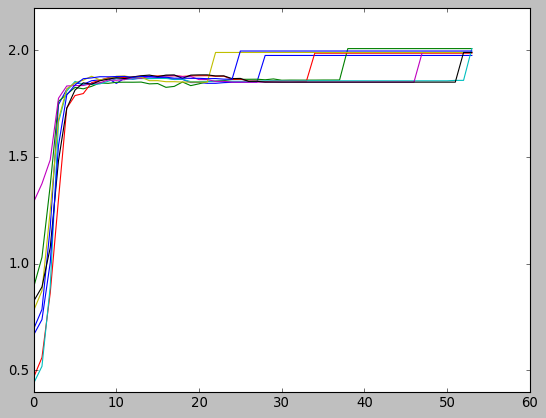

In [23]:
plt.plot(np.transpose(Arf))
plt.style.use("classic")
plt.axis("on")

In [24]:
np.savetxt(fname, Arf, delimiter=',')